# Sprocket Central Pty Ltd Company: Customers Recommendation project Phase #2 Exploratory Data analysis

## KPMG Virtual Intership

<img src="sprocket_central.png">

## About the Dataset
**Sprocket Central Pty Ltd**, a medium size bikes & cycling accessories organisation which has a large dataset relating to its customers, but their team is unsure how to effectively analyse it to help optimise its marketing strategy.

### The Files used in this Phase:
* **"customer_data_wrangling.csv"** : The file is the result of the Data Wrangling and Cleaning process in Phase #1.

### The Objective of This stage:
1. What're the trends in the underlying data?
2. Which customer segment has the higher value?

In [1]:
# import all packages and set plots to be embedded inline
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import calendar
import scipy.stats as stats
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("colorblind")

# suppress warnings 
import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv("customer_data_wrangling.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19773 entries, 0 to 19772
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   transaction_id                       19773 non-null  int64  
 1   product_id                           19773 non-null  int64  
 2   customer_id                          19773 non-null  int64  
 3   transaction_date                     19773 non-null  object 
 4   online_order                         19773 non-null  int64  
 5   order_status                         19773 non-null  object 
 6   brand                                19773 non-null  object 
 7   product_line                         19773 non-null  object 
 8   product_class                        19773 non-null  object 
 9   product_size                         19773 non-null  object 
 10  list_price                           19773 non-null  float64
 11  standard_cost               

### Some Observation on the General Information:

1. **transaction_id, product_id, customer_id Transaction_year, Transaction_day, postcode** are int --> change to string.
2. **transaction_date, product_first_sold_date** is string --> change to datetime.
3. change all categorical data from string into category datatype.
4. **tenure, Age, property_valuation** are float --> change to int.
5. drop **_merge**.
6. **online_order** is int --> change to bool.
6. create **age_group** column by segmenting **age** into defined set of age groups.

In [4]:
#perform observation (1)
to_string_list = ['transaction_id', 'product_id', 'customer_id', 'Transaction_year', 'Transaction_day', 'postcode']
for col in to_string_list:
    df[col] = df[col].astype(str)

In [5]:
#perform Observation (2)
to_datetime_list = ['transaction_date', 'product_first_sold_date']
for col in to_datetime_list:
    df[col] = pd.to_datetime(df[col])

In [6]:
#perform observation (3)
to_category_list = [col for col in df.columns if ((df[col].dtype=='object') & (col not in to_string_list))]
for col in to_category_list:
    df[col] = df[col].astype('category')

In [7]:
#prform observation (4)
to_int_list = ['tenure', 'Age', 'property_valuation']
for col in to_int_list:
    df[col] = df[col].astype(int)

In [8]:
#perform observation (5)
df.drop(axis=1, columns='_merge', inplace=True)

In [9]:
#perform observation (6)
df.online_order = df.online_order.astype(bool)

In [10]:
#cheching for max age and min age in the customers data
print(df.Age.min())
print(df.Age.max())

20
90


In [11]:
#perform observation (7) -- crating age_group column
age_group = pd.cut(df.Age, bins = [20,30,40,50,60,70,80,90], labels=['20-30','31-40','41-50','51-60','61-70','71-80', '81-90'])
df.insert(26, 'age_group', age_group)
df.head(1)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,Age,age_group,postcode,state,property_valuation
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,...,Financial Services,Mass Customer,No,Yes,10,67,61-70,3064.0,VIC,6


### Features that will help support our investigation:

1. List price
2. Standard cost
3. past_3_years_bike_related_purchases
4. Age
5. age_group
6. Transaction_month
7. day_of_the_week
8. wealth_segment
9. state
10. Gender
11. owns_car
12. postcode

In [12]:
df.describe()

,list_price,standard_cost,past_3_years_bike_related_purchases,tenure,Age,property_valuation
count,19773.000000,19773.000000,19773.000000,19773.000000,19773.000000,19773.000000
mean,1108.043581,556.091050,48.783746,10.669195,44.139079,7.515400
std,582.845663,405.966472,28.602835,5.612428,12.477642,2.825641
min,12.010000,7.210000,0.000000,1.000000,20.000000,1.000000
25%,575.270000,215.140000,24.000000,6.000000,35.000000,6.000000
50%,1163.890000,507.580000,48.000000,10.000000,44.000000,8.000000
75%,1635.300000,795.100000,73.000000,15.000000,53.000000,10.000000
max,2091.470000,1759.850000,99.000000,22.000000,90.000000,12.000000


## Univariate Exploration
In this section, we will investigate distributions of individual variables. If we see unusual points or outliers, we will take a deeper look to clean things up and prepare ourself to look at relationships between variables.

In [13]:
#draw distribution of numeric univariate feautres
def numeric_plot(df, col, title, xlabel):
    fig, ax = plt.subplots(figsize=(7,4),dpi=100)
    sns.distplot(df[col], ax=ax)
    ax.set(xlabel=xlabel, title=title)
    ax.axvline(x=df[col].mean(), color='r',label='Mean', linestyle='--')
    ax.legend()
    print("{} has mean = {}".format(col, df[col].mean()))
    print("{} has mode = {}".format(col, df[col].mode()[0]))
    print("{} has median = {}".format(col, df[col].median()))

In [14]:
#draw distribution of categorical feautres
def categorical_plot(df, col, title, xlabel):
    plt.figure(figsize=(7,4),dpi=100)
    sns.barplot(x=df[col].value_counts().index,y= df[col].value_counts()/df.shape[0], color=sns.color_palette()[0]);
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    print("{} has mode = {}".format(col, df[col].mode()[0]))

list_price has mean = 1108.0435811460331
list_price has mode = 2091.47
list_price has median = 1163.89


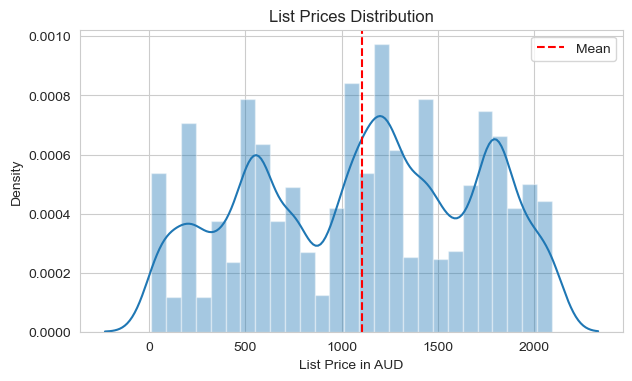

In [15]:
numeric_plot(df, 'list_price', "List Prices Distribution", 'List Price in AUD')

**About Graph:** List Prices are almost uniformaly distributed with mean at 1108.04 AUD, There's no outliers.

standard_cost has mean = 556.091049916564
standard_cost has mode = 388.92
standard_cost has median = 507.58


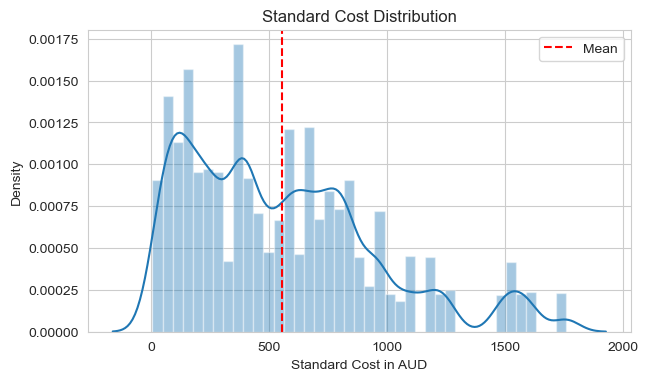

In [16]:
numeric_plot(df, 'standard_cost', 'Standard Cost Distribution', 'Standard Cost in AUD')

**About Graph:** The standard_cost is rght skewed, most of the product cost range from (0 to 1250 AUD) while there are some out liers from (1500 to 1750 AUD) with 1750 AUD being the extreme ouutlier.
* The **mean** is affected by the outliers skewed right by the value range of (1500 to 1750 AUD).
* While, the **mode** is the most representative describtive measure of this feature.

past_3_years_bike_related_purchases has mean = 48.78374551155616
past_3_years_bike_related_purchases has mode = 16.0
past_3_years_bike_related_purchases has median = 48.0


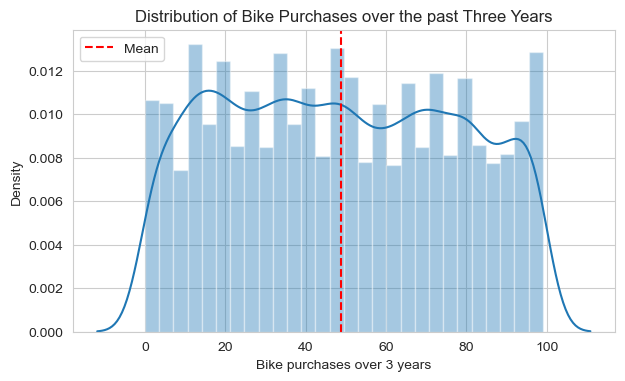

In [17]:
numeric_plot(df, 'past_3_years_bike_related_purchases',
             'Distribution of Bike Purchases over the past Three Years', 'Bike purchases over 3 years')

**About Graph:** This is a uniformally distributed feature, with no outliers.

Age has mean = 44.13907854144541
Age has mode = 44
Age has median = 44.0


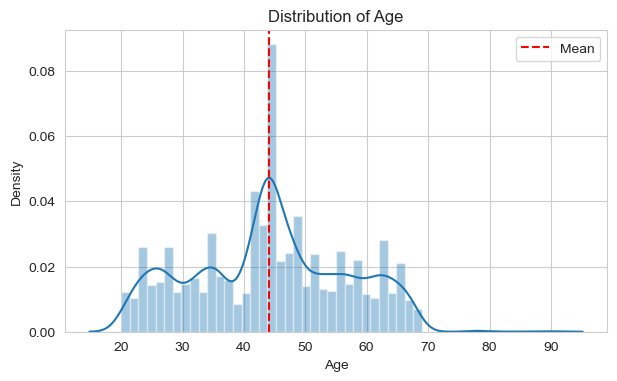

In [18]:
numeric_plot(df, 'Age', 'Distribution of Age', 'Age')

**About Graph:** Age is Normally distributed at the age range from 20 to 70 years old, with outliers from 75 to 90 years old.

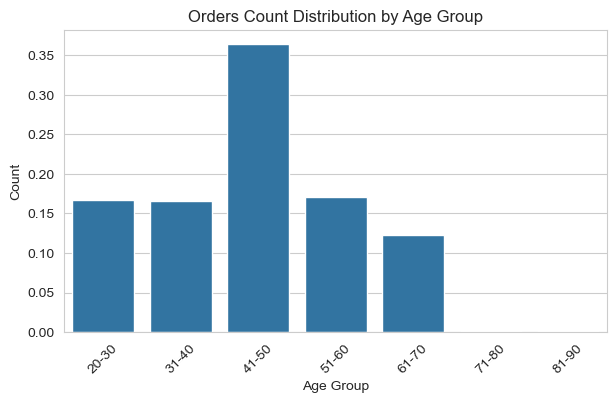

age_group has mode = 41-50


In [19]:
categorical_plot(df, 'age_group', 'Orders Count Distribution by Age Group', 'Age Group')

**About Graph:** Most of the purchases are done by 41-50 age group, most likely parents, the presence of the outliers is evident here from 71-90 ages.

--> Remove the outlier groups.

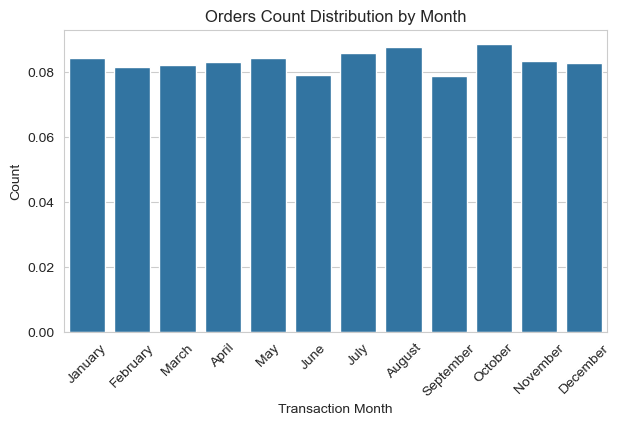

Transaction_month has mode = October


In [20]:
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July','August','September','October','November','December']
month_categ = pd.api.types.CategoricalDtype(ordered=True, categories=month)
df['Transaction_month'] = df['Transaction_month'].astype(month_categ)
categorical_plot(df,'Transaction_month', 'Orders Count Distribution by Month', 'Transaction Month')

**About Graph:** The distribution is uniform, There's no evident seasonal effect on sales.

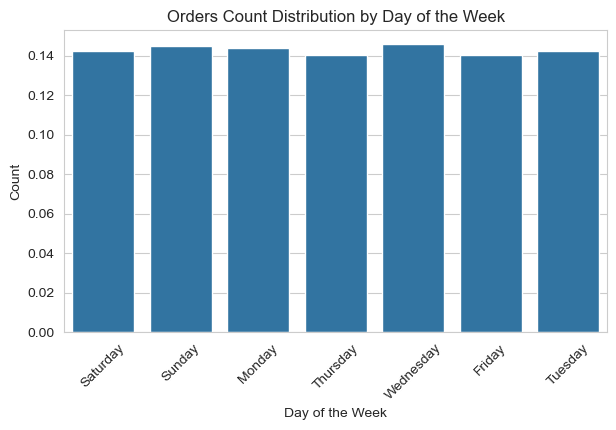

day_of_the_week has mode = Wednesday


In [21]:
weekday = ['Saturday', 'Sunday', 'Monday', 'Thursday', 'Wednesday', 'Friday', 'Tuesday']
weekday_categ = pd.api.types.CategoricalDtype(ordered=True, categories=weekday)
df.day_of_the_week = df.day_of_the_week.astype(weekday_categ)
categorical_plot(df,'day_of_the_week', 'Orders Count Distribution by Day of the Week', 'Day of the Week')

**About Graph:** The distribution is uniform, There's no evident seasonal effect on sales.

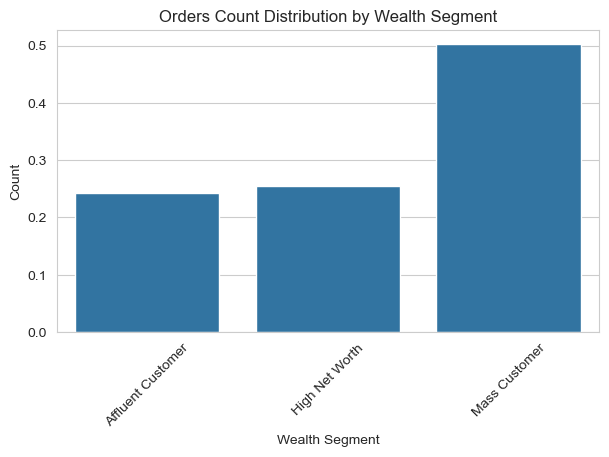

wealth_segment has mode = Mass Customer


In [22]:
#plotting Distribution of Transactions by wealth_segment
categorical_plot(df, "wealth_segment", "Orders Count Distribution by Wealth Segment", "Wealth Segment")

**About Graph:** There's an evident domination of 50% of the purchase orders done by "Mass Customer".

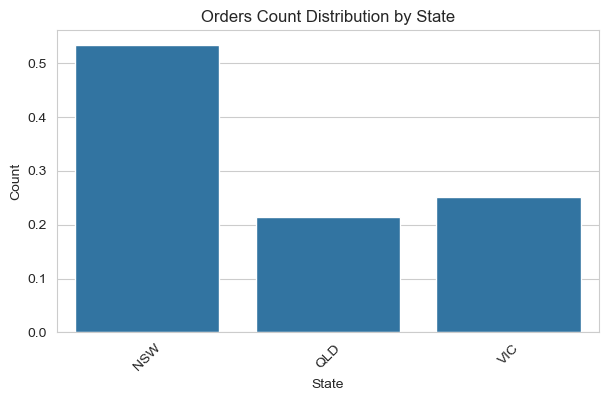

state has mode = NSW


In [23]:
categorical_plot(df, "state", "Orders Count Distribution by State", "State")

**About Group:** Almost 55% of the purchase orders done by customers from New South Wales State.

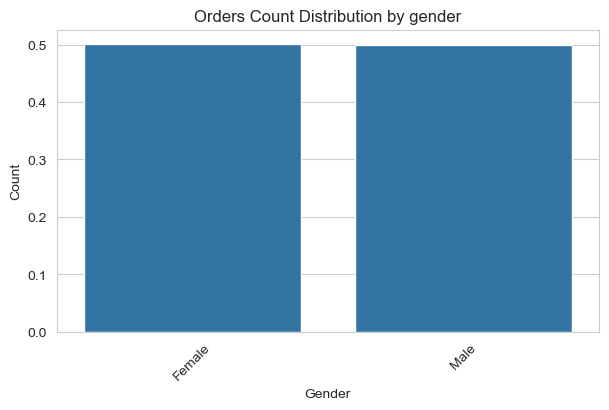

gender has mode = Female


In [24]:
categorical_plot(df, "gender", "Orders Count Distribution by gender", "Gender")

**About Graph:** Also, Females are more (51%) than Males (49%) the difference dosen't make any difference (It's only 1 %).

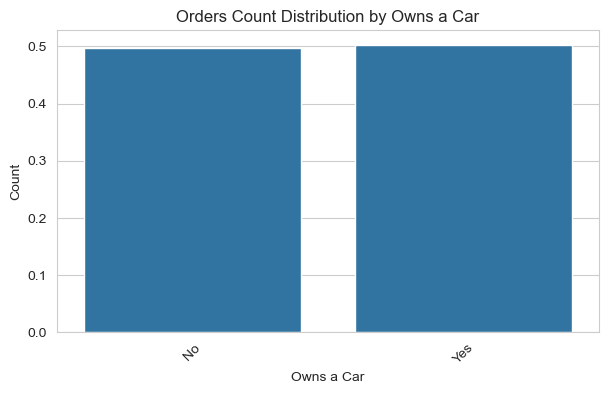

owns_car has mode = Yes


In [25]:
categorical_plot(df, "owns_car", "Orders Count Distribution by Owns a Car", "Owns a Car")

**About Graph:** Also, customers who own cars has more orders than those who don't, the difference is not much.

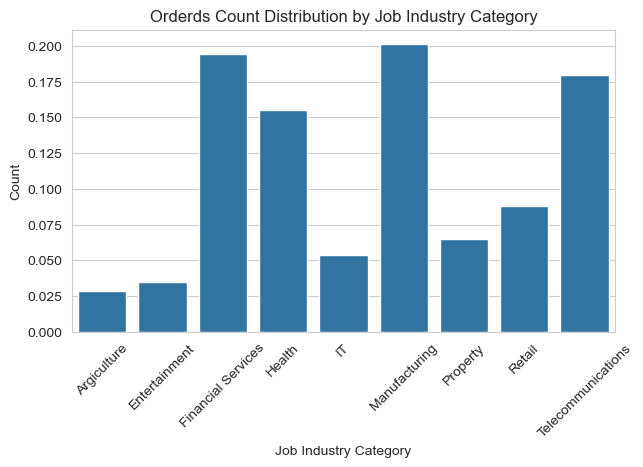

job_industry_category has mode = Manufacturing


In [26]:
categorical_plot(df, "job_industry_category", "Orderds Count Distribution by Job Industry Category", "Job Industry Category")

**About Graph:** Most of the orders came from customers who work in, 

(Manufacturing --> Financial Services --> Telecommunications --> Health) ordered descendly all are between 17.5% and 20% of the data.


### Feautre Engineering:
constructing **standard_profit** column = **list_price** - **standard_cost**

In [27]:
df['standard_profit'] = df.list_price - df.standard_cost

standard_profit has mean = 551.9525312294477
standard_profit has mode = 1702.5499999999997
standard_profit has median = 445.2099999999999


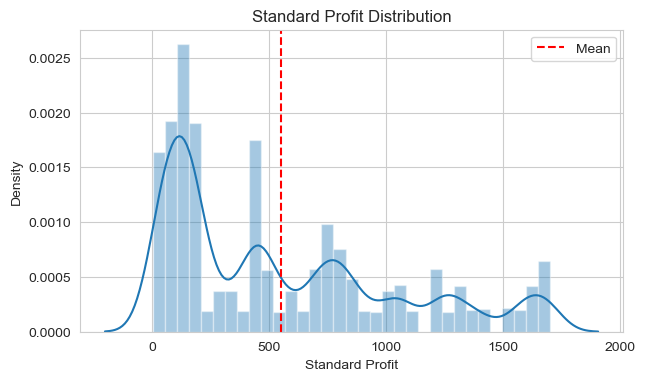

In [28]:
numeric_plot(df, 'standard_profit', 'Standard Profit Distribution', 'Standard Profit')

**About Graph:** The distribution of the profit and the fact that it's write skewed with no outliers contradict the effect of was considered to be outlier in standard_cost, Although it's outlier of cost but it dosen't affect the over all skewness of Financial status of the sales operations.

**The distribution(s) of variable(s) of interest:**

1. From the distribution of prices we notice that we have a normally distributed data with no outliers the average of the prices is 1106.
2. For Standard cost We have a positively skewed (right-skewed) distribution with some outliers, the average of the cost in dollars is 555.
3. Ages in the data are mostly distributed between 20s and 60s, the most demanding age of our customers range from 30 to mid 40s which makes sense since they are in the peak of their youth and trying to mantain their health and excercise more, the average age is 43, and age groups 70s to 90s are few outliers of the normally distributed data.
4. purchases related to bikes is the purchases made by our customer in the past three years related to bikes , we have a normally distributed data with no outliers,the mean of the purchases in the past three years is 48.
5. The amount of orders along the year is almost the same, with not seasonal changes of considerable effect on the data distribution by count.
6. Althought the amount of bikes sold along the week is almost the same but we can identify a increase of amount on wednesday.
7. (Mass customers) represents 50% of the orders,(Affluent customers) represents 24% of the orders,(High net worth customers) represents 25% of the orders.
8. Most of our orders come from New South wales state, since it has 50% of our orders.
9. Distribution of orders between men and women are almost the same , 51% of our orders are from women and 49% are from men.
10. Most of our customers work at manufacturing industry.

**Unusual distributions:**

* **Age** had some outliers --> remove outliers.

In [29]:
df = df[(df.age_group != '71-80')&(df.age_group != '81-90')]
df.dropna(inplace=True)
df.isnull().sum().sum()

0

In [30]:
df[df.Age > 70].shape

(0, 31)

**Done with Univariate Exploration**

## Bivariant | Multivariant Exploration
constructing relation draws the effect of diffrent feautres on both revenue and profit.

In [31]:
def bivariant_cat(df, xcol, ycol, xlabel, ylabel, title, hue=None, size= (7,4),
                  color=sns.color_palette()[0], legend=False, kind='point', degree=0):
    agg_df = df.groupby([xcol, 'gender'], as_index=False)[ycol].sum()
    fig, ax = plt.subplots(figsize =size, dpi = 100)
    if kind == 'bar':
        sns.barplot(data = agg_df, x = xcol ,y=ycol, hue=hue, color=color, dodge=True);
    else:
        sns.pointplot(data = agg_df, x = xcol ,y=ycol, hue=hue, color=color, dodge=True);
    ax.set(xlabel=xlabel, ylabel= ylabel, title= title)
    if legend:
        ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05))
    plt.xticks(rotation=degree)

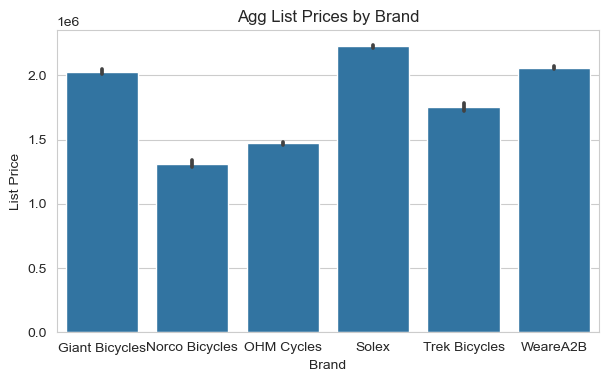

In [32]:
bivariant_cat(df, 'brand', 'list_price', 'Brand', "List Price", "Agg List Prices by Brand", kind='bar')

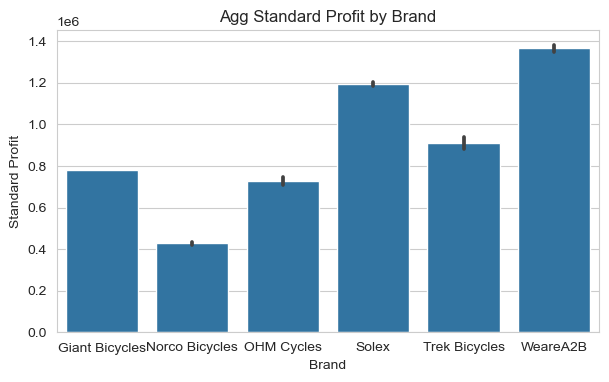

In [33]:
bivariant_cat(df, 'brand', 'standard_profit', 'Brand', "Standard Profit", "Agg Standard Profit by Brand", kind='bar')

**About Graphs:** Although, Giant Bicycles and WeareA2B both have almost equal revenue in terms of Aggregate **list_price**, WeareA2B has the higest profits with much distinction from other brands.

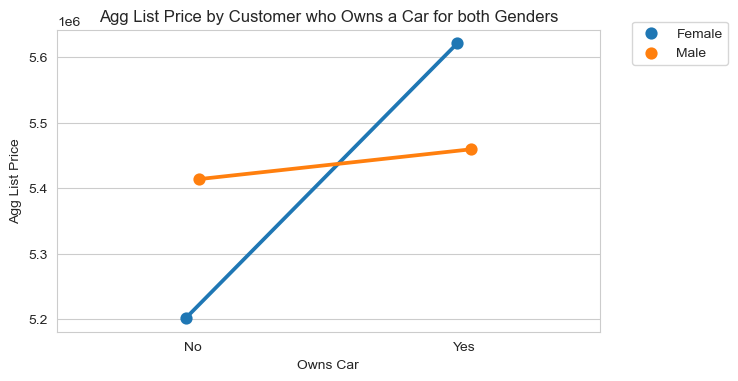

In [34]:
bivariant_cat(df, 'owns_car', 'list_price','Owns Car', 'Agg List Price',
              'Agg List Price by Customer who Owns a Car for both Genders', 'gender',
              legend=True, color=None)

**About Graph:** Revenue is almost equally distributed between customers who Owns a Car of those who don't, The attribute is of no much effect on Agg List Price.

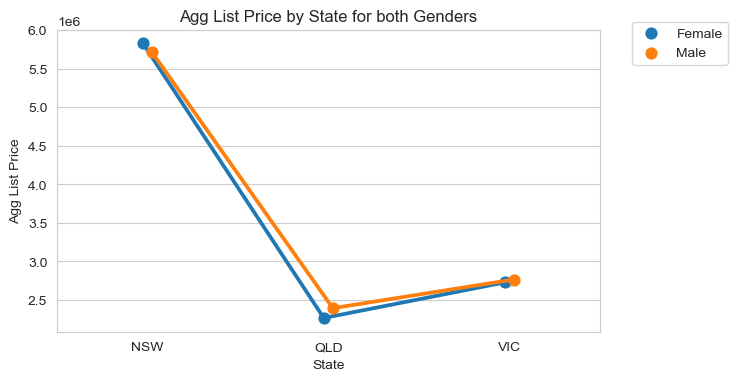

In [35]:
bivariant_cat(df, 'state', 'list_price','State', 'Agg List Price',
              'Agg List Price by State for both Genders', 'gender', legend=True, color=None)

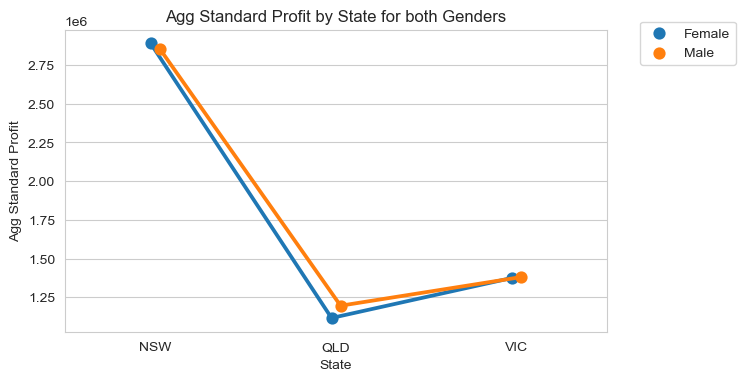

In [36]:
bivariant_cat(df, 'state', 'standard_profit','State', 'Agg Standard Profit',
              'Agg Standard Profit by State for both Genders', 'gender', legend=True, color=None)

**About Graph:** Both revenue and profit is almost equally distributed between orders done from the 3 States, The attribute is of no much effect on Agg List Price or Standard Profit.

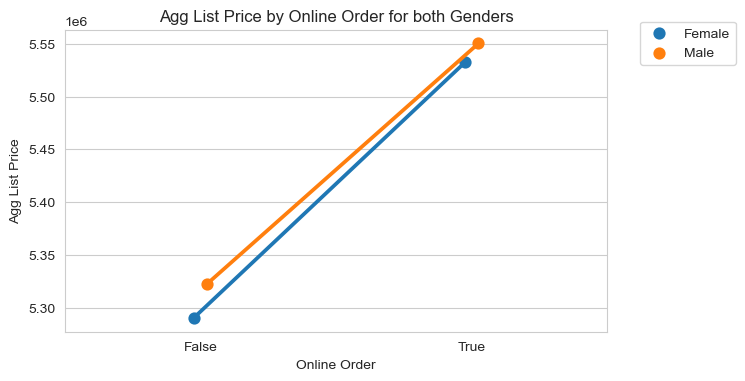

In [37]:
bivariant_cat(df, 'online_order', 'list_price','Online Order', 'Agg List Price',
              'Agg List Price by Online Order for both Genders', 'gender', legend=True, color=None)

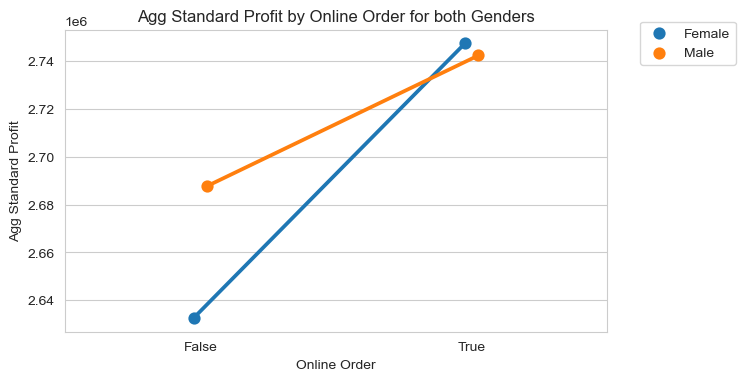

In [38]:
bivariant_cat(df, 'online_order', 'standard_profit','Online Order', 'Agg Standard Profit',
              'Agg Standard Profit by Online Order for both Genders', 'gender', legend=True, color=None)

**About Graph:** Both revenue and profit is almost equally distributed between orders done online and offline, The attribute is of no much effect on Agg List Price or Standard Profit.

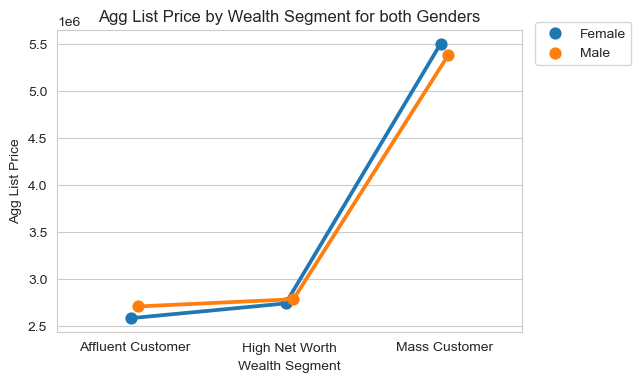

In [39]:
bivariant_cat(df, 'wealth_segment', 'list_price','Wealth Segment', 'Agg List Price',
              'Agg List Price by Wealth Segment for both Genders', 'gender', legend=True, color=None,size=None)

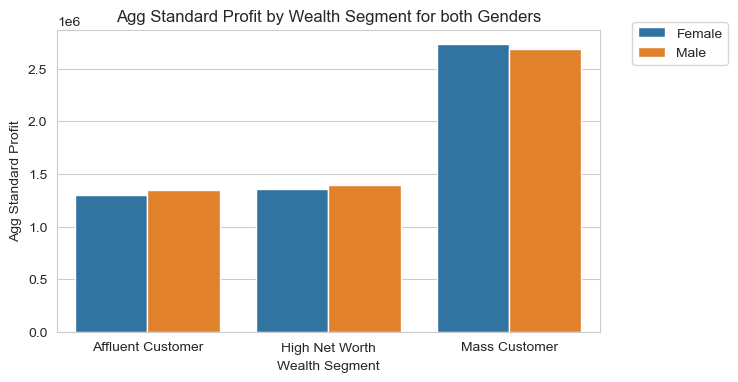

In [40]:
bivariant_cat(df, 'wealth_segment', 'standard_profit','Wealth Segment', 'Agg Standard Profit',
              'Agg Standard Profit by Wealth Segment for both Genders', 'gender', legend=True, color=None, kind='bar')

**About Graph:** Although revenue is almost equal from Affluent and Mass Customers, Profit from Affluent Customer is the most.

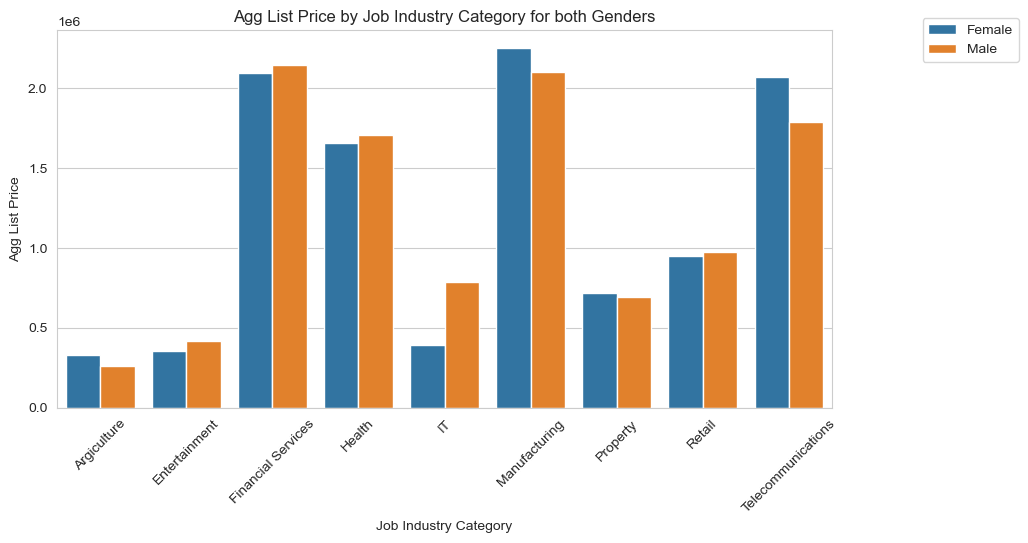

In [41]:
bivariant_cat(df, 'job_industry_category', 'list_price','Job Industry Category', 'Agg List Price',
              'Agg List Price by Job Industry Category for both Genders', 'gender',
              legend=True, color=None, kind='bar', degree=45, size=(10,5))

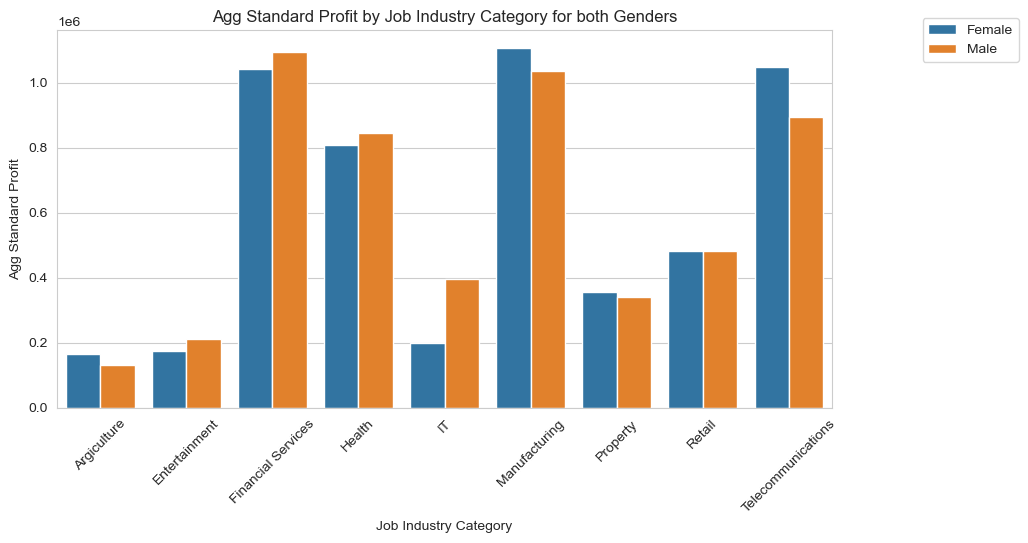

In [42]:
bivariant_cat(df, 'job_industry_category', 'standard_profit','Job Industry Category', 'Agg Standard Profit',
              'Agg Standard Profit by Job Industry Category for both Genders', 'gender',
              legend=True, color=None, kind='bar', degree=45, size=(10,5))

**About Graph:** Both Revenue and Profit show increase in (Manufacturing --> Financial Services --> Telecommunications)

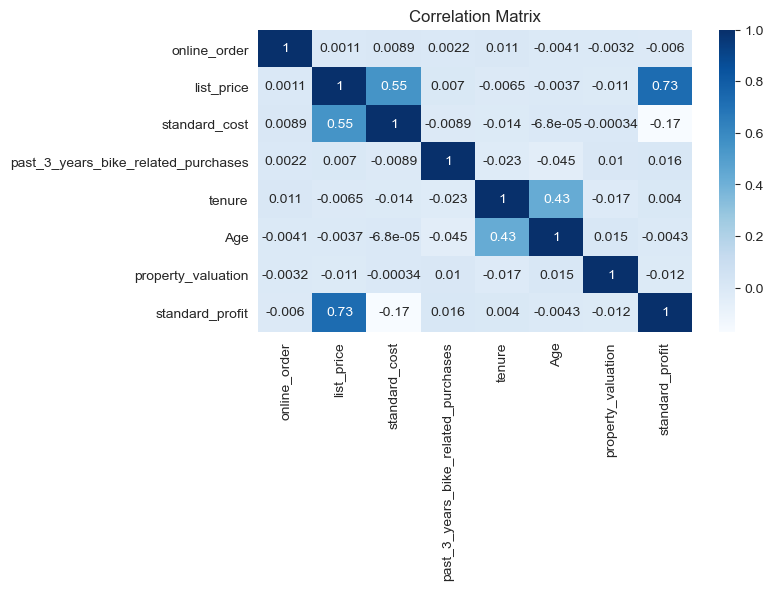

In [43]:
#correlation matrix
plt.figure(figsize = (7,4), dpi = 100);

sns.heatmap(df.corr(), cmap="Blues", annot = True);
plt.title("Correlation Matrix");
plt.xticks(rotation = 90);

plt.show();

**About Graph**: The Map states that there are no strong correlations among data, aside from the obvious one of cost and price.



#### **Interesting Obesrevations from this stage of Explotary Analysis:**

1. Most of the profits has been gaind from mass customers by males.
2. Males in Manufacturing industry generated more profits than any other category.
3. There are no strong correlations among numerical data.

## RFM Analysis:
Now let's start doing a RFM analysis which is segmenting customers throught thier:
1. Recency(Recent purchases, #days since last purchase)
2. Frequency(How many purchases have they done)
3. Monetary (How much profit have they given the company).

In [44]:
# This is a quick code to calculate Recency , frequency , monetary for each customer
end_date = max(df['transaction_date']) + dt.timedelta(days=1)

df_rfm = df.groupby('customer_id').agg(
    recency=('transaction_date', lambda x: (end_date - x.max()).days),
    frequency=('transaction_id', 'count'),
    monetary=('standard_profit', 'sum')
).reset_index()

df_rfm.head()

,customer_id,recency,frequency,monetary
0,1,8,11,3018.09
1,100,12,2,877.40
2,1000,1,9,5383.48
3,1001,43,7,2884.19
4,1002,156,4,2254.56


In [45]:
df_rfm.describe()

,recency,frequency,monetary
count,3456.000000,3456.000000,3456.000000
mean,62.246528,5.666956,3127.942911
std,58.356680,2.312720,1773.612867
min,1.000000,1.000000,15.080000
25%,18.000000,4.000000,1837.127500
50%,45.000000,6.000000,2859.715000
75%,86.000000,7.000000,4186.187500
max,354.000000,14.000000,11668.950000


In [46]:
# splitting customer into segments using quantiles
quantiles=df_rfm.quantile(q=[0.25,0.5,0.75])

In [47]:
# checking segments
quantiles.to_dict()

{'recency': {0.25: 18.0, 0.5: 45.0, 0.75: 86.0},
 'frequency': {0.25: 4.0, 0.5: 6.0, 0.75: 7.0},
 'monetary': {0.25: 1837.1275, 0.5: 2859.715, 0.75: 4186.1875}}

In [48]:
# Segmentting data into four groups using quantiles 

## for Recency 

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
## for Frequency and Monetary value 

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1  

In [49]:
# apply the function to each rfm column to create segment for each customer in each r,f,m column
df_rfm['R'] = df_rfm['recency'].apply(RClass, args=('recency',quantiles))
df_rfm['F'] = df_rfm['frequency'].apply(FMClass, args=('frequency',quantiles))
df_rfm['M'] = df_rfm['monetary'].apply(FMClass, args=('monetary',quantiles))

In [50]:
#calculating RFM class by concatenating the score of each r,f,m & calculating the RFM score by summing the r,f,m segments
df_rfm['RFMClass'] = df_rfm['R'].map(str) + df_rfm['F'].map(str) + df_rfm['M'].map(str)
df_rfm['RFMscore']= df_rfm[['R','F','M']].sum(axis=1)

In [51]:
#checking results
df_rfm.head()

,customer_id,recency,frequency,monetary,R,F,M,RFMClass,RFMscore
0,1,8,11,3018.09,1,1,2,112,4
1,100,12,2,877.40,1,4,4,144,9
2,1000,1,9,5383.48,1,1,1,111,3
3,1001,43,7,2884.19,2,2,2,222,6
4,1002,156,4,2254.56,4,4,3,443,11


<Figure size 800x400 with 0 Axes>

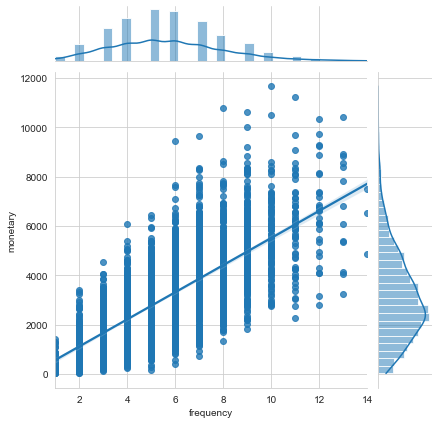

In [52]:
#checking for relation between Frequency and Monetary
plt.figure(figsize=(8,4),dpi=100);
sns.jointplot(x='frequency',y='monetary',data=df_rfm,kind='reg');

**Graph conclusion:** Visual shows a strong +ve relationship between Frequency and Monetary

--> Normally, **The more the customer makes purchase orders, the more the profit**.

<Figure size 800x400 with 0 Axes>

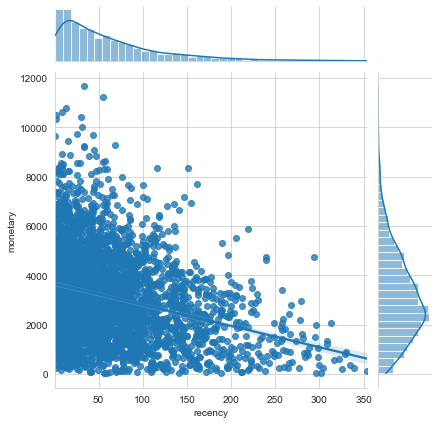

In [53]:
#checking for relation between Recency and Monetary
plt.figure(figsize=(8,4),dpi=100);
sns.jointplot(x='recency',y='monetary',data=df_rfm,kind='reg');

**Graphic conclusion:** Visual shows a strong -ve relationship between Recency and Monetary

--> **On recent days, #orders has been decreasing**.

In [54]:
# Assigning Loyality level to each customer using qcut method which segments data as per number of quantiles decided
Loyality_level=['Platinum','Gold','Silver','Bronze']
score_cuts=pd.qcut(df_rfm['RFMscore'],q=4,labels=Loyality_level)
df_rfm['RFM_loyalty_level']= score_cuts.values
df_rfm.head()

,customer_id,recency,frequency,monetary,R,F,M,RFMClass,RFMscore,RFM_loyalty_level
0,1,8,11,3018.09,1,1,2,112,4,Platinum
1,100,12,2,877.40,1,4,4,144,9,Silver
2,1000,1,9,5383.48,1,1,1,111,3,Platinum
3,1001,43,7,2884.19,2,2,2,222,6,Platinum
4,1002,156,4,2254.56,4,4,3,443,11,Bronze


In [55]:
# joinning dataset
df_rfm_allinone =df.merge(df_rfm,on='customer_id',how='inner')

**Finally we have segmented customer into 4 different segments and we should prioritize our marketing strategy as per each segment,now we will shift to phase 3 from our project which is Machine learning modeling.**

In [56]:
# Exporting our CTA dataframe to use it in phase 3 from our project
df_rfm_allinone.to_csv('customer_data_RFM_Analysis.csv')